pretext tasks:
- shuffle the order of slices in sandwich, figure out correct slice order?

- jigsaw?

# Center Crop fastmri tfm??

## Setup gdrive

In [ ]:
PROJ       = "fastmri"

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [ ]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


In [ ]:
%run "$PROJ_PATH/04_kspace_tfms.ipynb" # get the tfms to test

## Setup

In [ ]:
PROJ       = "fastmri"

# clone repo
!git clone https://github.com/RGologorsky/fastmri.git

# pip install/import
%run "$PROJ/common_constants_env.ipynb" # pip install fastai, fastmri, etc
%run "$PROJ/common_archs.ipynb"         # get simple cnn (stride 2 all the way)
%run "$PROJ/04_kspace_tfms.ipynb"       # get the kspace tfms

Cloning into 'fastmri'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 301 (delta 1), reused 5 (delta 1), pack-reused 292
Receiving objects: 100% (301/301), 18.93 MiB | 28.22 MiB/s, done.
Resolving deltas: 100% (107/107), done.
pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


In [ ]:
%run "$PROJ/04_kspace_tfms.ipynb"       # get the kspace tfms

# Raw Items 

Fnames

1. Highres: MR image from **fully sampled ksapce**
2. Lowres: MR image from **undersampled kspace**

Get raw items. Raw items: list of (fname, attribute dict), derived from fn2attr.json stored in Gdrive. The attribute dict contains relevant info such as number of slices in the given h5 file.

In [ ]:
from google.colab import drive
from pathlib      import Path
import json

# choose dataset
ds_name = "knee_singlecoil_val"
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

# Mount Google Drive 
ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

# Path to Proj
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ

# Load json containing attr info
path_json = PROJ_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
fn2attr = json.load(path_json)
fn2attr_items = L(i for i in fn2attr.items())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 # Sandwich Tfm

Given index, return sandwich at that index.

Setup/init: 
- pass a list of (fname, attribute_dict), each fname contains a kspace volume.
- pass $n_{seq}$, the desired sequence length. For example  n_seq=5 yields a kslice sequence of length 5, ($x$-2, $x$-1, $x$, $x$+1, $x$+2).

Encode: given index, 
- look up the correct file to open, 
- find the right slice sequence ($x$-2, $x$-1, $x$, $x$+1, $x$+2),
- return slice sequence and target slice $x$.

In [ ]:
# indexes into array of kspace slices
class ToSandw(Transform):

  # returns index in fn2attr corresponding to given sandwich
  def sandw2fn_idx(self, i): return np.searchsorted(self.cumsum_n_sandws, i)

  def __init__(self, fn2attr_items, n_seq = 5):
    self.fn2attr_items, self.n_seq = fn2attr_items, n_seq
    
    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

  def encodes(self, sandw_idx):
    # get file
    fn_idx  = self.sandw2fn_idx(sandw_idx)
    fname   = self.fn2attr_items[fn_idx][0]

    # sandwich index within file
    n_sandw_prior_vol = 0 if fn_idx == 0 else self.cumsum_n_sandws[fn_idx - 1]
    sw_idx   = sandw_idx - n_sandw_prior_vol
    
    # get kspace sandwich, target slice + neighbor slices on either side
    with h5py.File(fname, 'r') as data:
      ksandw = data['kspace'][sw_idx:sw_idx+self.n_seq]      
      target = data['kspace'][sw_idx + self.n_seq//2]

    return T.to_tensor(ksandw), T.to_tensor(target)


In [ ]:
print(*fn2attr_items[:5], sep="\n")

('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000631.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000314.h5', {'n_slices': 32, 'kspace_shape': [32, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000031.h5', {'n_slices': 40, 'kspace_shape': [40, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000480.h5', {'n_slices': 33, 'kspace_shape': [33, 640, 372], 'padding_left': 19, 'padding_right': 354})
('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/file1000071.h5', {'n_slices': 35, 'kspace_shape': [35, 640, 372], 'padding_left': 19, 'padding_right': 354})


In [ ]:
shapes = [tuple(o[1]["kspace_shape"][1:]) for o in fn2attr_items]
list(set(shapes))

[(640, 454), (640, 400), (640, 644), (640, 372)]

# Crappifier

Highres $\to$ Lowres 

(mask some lines in kspace)

Lowres = given fully-sampled kspace, mask some kspace lines:
- center fractions: #kspace lines in central region (8% or 4% of highres kspace lines)
- acceleration factor: #kspace lines overall  (4x or 8x less than highres)


For example, if accelerations = [4, 8] and center_fractions = [0.08, 0.04], then there is a 
- 50% probability that 4-fold acceleration with 8% center fraction is selected and a 
- 50% probability that 8-fold acceleration with 4% center fraction is selected.

In [ ]:
from common.subsample import RandomMaskFunc

# highres ds to lowres ds
class ToLRTfm(Transform):
  def __init__(self, hr_ds, center_frac=[0.08, 0.04], accel = [4,8], seed=42):
    self.hr_ds = hr_ds
    self.mask_func = RandomMaskFunc(center_fractions=center_frac, accelerations=accel)
    if seed: self.mask_func.rng.seed(seed)
    self.set_masks()
    
  def encodes(self, sandw_idx):
    vol_idx        = self.hr_ds.sandw2fn_idx(sandw_idx)
    mask           = self.masks[vol_idx]
    ksandw, target = self.hr_ds[sandw_idx]
    return ksandw * mask + 0.0, target
  
  # gets attr from highres ds
  def get_attr(self, i, a): return self.hr_ds.fn2attr_items[i][1][a]
  def set_masks(self):
    self.masks = [self.get_mask(self.get_attr(i, "kspace_shape")) 
                    for i in range(len(self.hr_ds.fn2attr_items))]

  # no padding
  def get_mask(self, shape):
    shape = np.array(shape)
    shape[:-3] = 1
    shape = np.append(shape, 2)
    return self.mask_func(shape)

  # maybe later see if padding needed
  # padding  = self.get_attr(i, "padding_left"), self.get_attr(i, "padding_right")
  # if padding is not None:
  #     mask[:, :, :padding[0]] = 0
  #     mask[:, :, padding[1]:] = 0 # padding value inclusive on right of zeros

# Datasets

Highres:
1. input: fully kspace seq, $X_i = \{x_{i-2}, x_{i-1}, x_i, x_{i+1}, x_{i+2} \}$
2. target: fully sampled middle slice, $T_i$

Lowres:
1. input: undersampled kspace seq, $X_i = \{x_{i-2}, x_{i-1}, x_i, x_{i+1}, x_{i+2} \}$
2. target: fully sampled middle slice, $T_i$

In [ ]:
# setup the transform
sandw_tfm = ToSandw(fn2attr_items, n_seq=5)
print(f"total #sandwiches = {sandw_tfm.total_n_sandws}")

# dataset = indices, sandw_tfm converts index to sandwich
hr_raw_items = range(sandw_tfm.total_n_sandws)

# split between training/valid
hr_splitter = RandomSplitter(valid_pct=0.2, seed=42)
hr_splits   = hr_splitter(hr_raw_items)
print(f"#train/#valid = {len(hr_splits[0]), len(hr_splits[1])}")

hr_ds = TfmdLists(hr_raw_items, tfms=[sandw_tfm], splits=hr_splits)

#  crappify_tfm masks fully-sampled kspace sandw, target unchanged
lr_tfm =  ToLRTfm(hr_ds = hr_ds, center_frac=[0.08, 0.04], accel = [4,8], seed=42)
lr_ds  = TfmdLists(hr_raw_items, tfms=[lr_tfm], splits=hr_splits)

# Other splitters
#splitter = GrandparentSplitter(valid_name="val")
#splitter = RandomSplitter(valid_pct=0.2, seed=42)

# Furether tfms
#tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()])


total #sandwiches = 1196
#train/#valid = (957, 239)


In [ ]:
i = 60
fn_idx = sandw_tfm.sandw2fn_idx(i)
fname = sandw_tfm.fn2attr_items[fn_idx][0]
n_sandw_prior_vol = 0 if fn_idx == 0 else sandw_tfm.cumsum_n_sandws[fn_idx - 1]
sw_idx   = i - n_sandw_prior_vol

print(f"idx = {i}")
print(f"cumsum sandwd {sandw_tfm.cumsum_n_sandws}")
print(f"fn idx {fn_idx}")
print(f"nsand prior {n_sandw_prior_vol}")
print(f"sw idx {sw_idx}")

idx = 60
cumsum sandwd [  36   64  100  129  160  191  220  246  272  304  332  362  394  424
  460  486  518  544  570  600  632  663  692  718  752  778  810  840
  870  901  928  959  991 1017 1045 1076 1104 1134 1162 1196]
fn idx 1
nsand prior 36
sw idx 24


In [ ]:
# converts complex k-space (2channel) to amplitude k-space (1channel)
class K2ImTfm(Transform):
  def encodes(self, t:Tensor): return C.apply(t, CenteredTfms.k2im())

In [ ]:
sz = (640,372)
rsz = Resize(sz, method="crop", pad_mode="reflection")

In [ ]:
# center crop, same size partial(T.center_crop, shape=sz)
crop_tfms = [lr_tfm, K2ImTfm, partial(T.complex_center_crop, shape=sz), partial(C.apply, tfms=C.complex2mgn)]
crop_lr_ds = TfmdLists(hr_raw_items, tfms=crop_tfms, splits=hr_splits)

# Viz datasets

In [ ]:
def toL(t): return [t[i] for i in range(t.shape[0])]

def quick_decode(k, header=None, footer="*"):
  if header: print(f"{header:*^30}")

  print(f"{'k input':30}: shape {k.shape}")

  # magnitude im space
  rev = C.apply(k, CenteredTfms.k2im(), post=C.complex2mgn)
  print(f"{'im magn':30}: shape {rev.shape}")

  # log magnitude kspace
  k_abs = C.apply(k, C.log, pre=C.complex2mgn)
  print(f"{'k log magnitude':30}: shape {k_abs.shape}")

  if footer: print(f"{footer:*^30}")
  return rev, k_abs

crop_im sandw: torch.Size([5, 640, 372])
crop_target sandw: torch.Size([640, 372])
Sandwich 509
************Masked************
k input                       : shape torch.Size([5, 640, 372, 2])
im magn                       : shape torch.Size([5, 640, 372])
k log magnitude               : shape torch.Size([5, 640, 372])
******************************
************Ksandw************
k input                       : shape torch.Size([5, 640, 372, 2])
im magn                       : shape torch.Size([5, 640, 372])
k log magnitude               : shape torch.Size([5, 640, 372])
******************************
************Target************
k input                       : shape torch.Size([640, 372, 2])
im magn                       : shape torch.Size([640, 372])
k log magnitude               : shape torch.Size([640, 372])
******************************


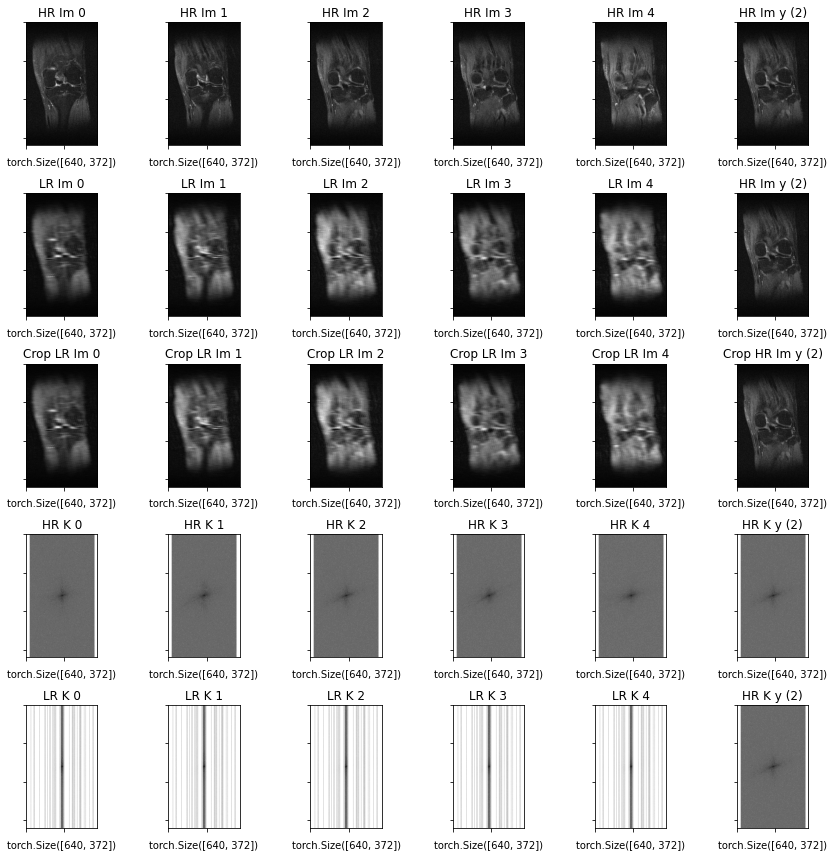

In [ ]:
i = np.random.randint(len(hr_ds))
ksandw, target     = hr_ds[i]
masked_ksandw, _   = lr_ds[i]

crop_im, crop_target = crop_lr_ds[i]
#crop_im     = C.apply(crop_im, C.complex2mgn)
#crop_target = C.apply(crop_target, C.complex2mgn)
print(f"crop_im sandw: {crop_im.shape}")
print(f"crop_target sandw: {crop_target.shape}")

print(f"Sandwich {i}")

rev_masked_ksandw, abs_masked_ksandw = quick_decode(masked_ksandw, header="Masked")
rev_ksandw, abs_ksandw = quick_decode(ksandw, header="Ksandw")
rev_target, abs_target = quick_decode(target, header="Target")

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

# MRs in (magnitude) image space
hr_ims  = toL(rev_ksandw) + [rev_target]
lr_ims  = toL(rev_masked_ksandw) + [rev_target]
crop_ims = toL(crop_im) + [crop_target]

# MRs in (log magnitude) kspace
hr_ks  = toL(abs_ksandw) + [abs_target]
lr_ks  = toL(abs_masked_ksandw) + [abs_target]

hr_im_titles  = [f"HR Im {i}" for i in range(n_seq)] + [f"HR Im y ({n_seq//2})"]
lr_im_titles  = [f"LR Im {i}" for i in range(n_seq)] + [f"HR Im y ({n_seq//2})"]
cr_im_titles  = [f"Crop LR Im {i}" for i in range(n_seq)] + [f"Crop HR Im y ({n_seq//2})"]

hr_k_titles  = [f"HR K {i}" for i in range(n_seq)] + [f"HR K y ({n_seq//2})"]
lr_k_titles  = [f"LR K {i}" for i in range(n_seq)] + [f"HR K y ({n_seq//2})"]

ims    =  hr_ims + lr_ims + crop_ims + hr_ks + lr_ks
titles = hr_im_titles + lr_im_titles + cr_im_titles + hr_k_titles + lr_k_titles

plot(ims, titles, nrows=5, ncols=n_seq+1, figsize=(12,12))

# Dataloaders

Define parameters

In [ ]:
bs = 8
num_workers = 1

Define dataloaders (learning in image space)

# Data Augs

TODO

In [ ]:
x,y = crop_lr_ds[0]
x.shape, y.shape

(torch.Size([5, 640, 372]), torch.Size([640, 372]))

In [ ]:
# sz = (640,372)
# rsz = Resize(sz, method="crop", pad_mode="reflection")

In [ ]:
sz = (640,372)

item_tfms  = []
batch_tfms = [] # partial(C.apply, tfms=C.complex2magn) [IntToFloatTensor] #, k2imTfm, Complex2Channel] # Normalize? SaveShape

crop_lr_dls = crop_lr_ds.dataloaders(
          after_item  = item_tfms, 
          after_batch = batch_tfms, 
          bs=bs, 
          num_workers = num_workers).cuda()

In [ ]:
#crop_lr_dls.train_ds
#crop_lr_dls.train_ds.tfms

In [ ]:
# x,y = crop_lr_dls.one_batch()

In [ ]:
# print(*[(i,lr_dls.train_ds[i][0].shape) for i in range(10)], sep="\n")
# lr_dls.train_ds
# lr_dls.train_ds.tfms -- list of tfms

xb torch.Size([3, 5, 640, 372]), yb torch.Size([3, 640, 372])


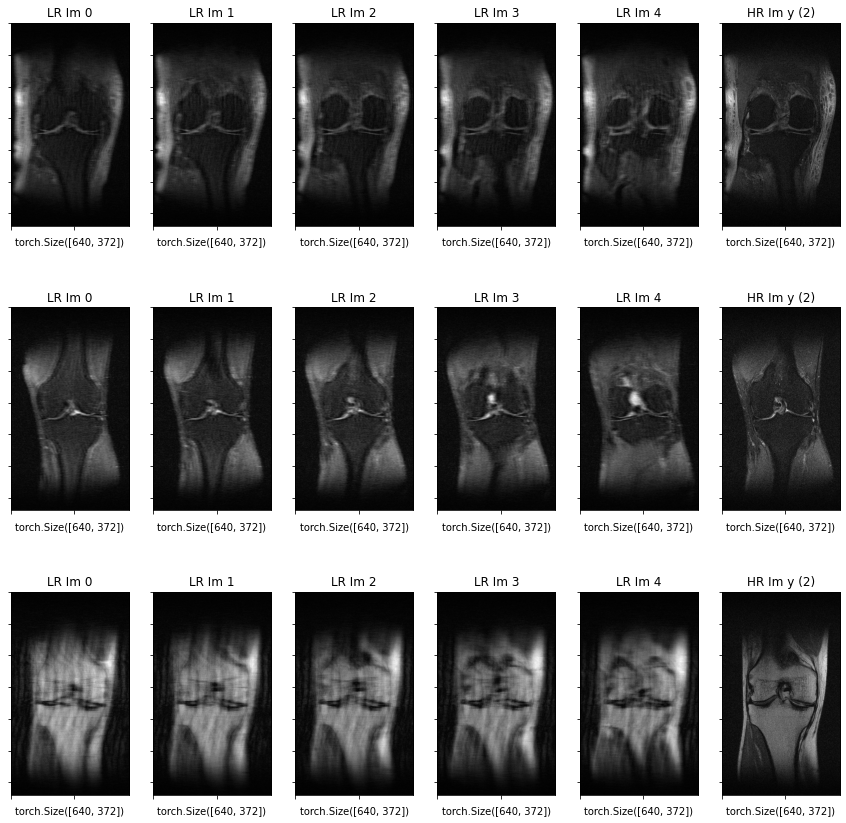

In [ ]:
# get batch
show_bs = 3

xb, yb = crop_lr_dls.one_batch()
xb, yb = to_cpu(xb)[:show_bs], to_cpu(yb)[:show_bs]
print(f"xb {xb.shape}, yb {yb.shape}")

# magnitude im space
rev_xb = xb #C.apply(xb, C.complex2mgn)
rev_yb = yb #C.apply(yb, C.complex2mgn)

# plot input sandwich + target slice
n_seq = sandw_tfm.n_seq

# MRs in (magnitude) image space - each row = (x slice sequence, HR y)
imspace  = [j for i in range(len(rev_yb)) for j in (*toL(rev_xb[i]), rev_yb[i])]

im_titles = L([f"LR Im {i}" for i in range(n_seq)] + [f"HR Im y ({n_seq//2})"]) * show_bs

ims =  imspace
titles = im_titles

plot(ims, titles, nrows=show_bs, ncols=n_seq+1, figsize=(12,12))

# Architecture

tofp16

In [ ]:
math.factorial(5)

120

In [ ]:
# base model: resnet
base_resnet = xresnet34

c_in = sandw_tfm.n_seq
n_out = math.factorial(c_in) # the number of permutations is c_in!
print(f"c_in = {c_in}, n_out = {n_out}")

complex_im_resnet   = base_resnet(c_in=c_in, n_out=n_out, pretrained=False)

c_in = 5, n_out = 120


In [ ]:
sys.path.append('/content/fastMRI/banding_removal/fastmri/common')

In [ ]:
!pip install runstats

     |████████████████████████████████| 112kB 4.3MB/s 
  Created wheel for runstats: filename=runstats-1.8.0-cp36-cp36m-linux_x86_64.whl size=200025 sha256=f8148dbf78fe42f5d2293816ad3eebcba71c4ee899dc75290e9e0405313670af
  Stored in directory: /root/.cache/pip/wheels/58/f0/2b/509c185283b7a501bcad14d5ab99fd614c80dcb1f894897d0e
Successfully built runstats


In [ ]:
import evaluate as E

In [ ]:
metrics = [E.nmse, E.psnr, E.ssim]

In [ ]:
learn = unet_learner(crop_lr_dls, complex_im_resnet, metrics=metrics, pretrained=False)

TypeError: ignored

In [ ]:
unet_learner??

In [ ]:
def unet_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on=None, blur:bool=False,
                 self_attention:bool=False, y_range=None, last_cross:bool=True,
                 bottle:bool=False, cut=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    
    # I have defined size intentionally like this, so that it won't be a problem when 
    # the input is an image 
    size = next(iter(data.train_dl))[0].shape[-2:]
    n_input_channels = next(iter(data.train_dl))[0][0].size(0)    
        
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    
    # changing the first layer to suit our input
    if not n_input_channels == 3: 
        prev_layer = body[0]
        body[0] = nn.Conv2d(n_input_channels, prev_layer.out_channels, 
                      kernel_size=prev_layer.kernel_size, 
                      stride=prev_layer.stride, 
                      padding=prev_layer.padding, 
                      bias=prev_layer.bias)

    model = to_device(models.unet.DynamicUnet(body, n_classes=data.c, img_size=size, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=y_range, norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    if pretrained and n_input_channels == 3: 
        learn.freeze()
        apply_init(model[2], nn.init.kaiming_normal_)
    else: apply_init(model, nn.init.kaiming_normal_)
    return learn